# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [2]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [3]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
from pathlib import Path


In [4]:
print(f"Torch: {torch.__version__}")

Torch: 2.1.0+cu118


In [5]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
device = 'cuda'

## Load Data

In [8]:
os.makedirs('data', exist_ok=True)

In [9]:
dataset_dir =r'C:\xpj\UNIPUS\OCR\ocrdataset\relevant_dataset'
with open(r'C:\xpj\github\vit-pytorch\examples\data\train.txt', 'r') as f:
    train_key = [line.strip() for line in f.readlines()]
with open(r'C:\xpj\github\vit-pytorch\examples\data\val.txt', 'r') as f:
    val_key = [line.strip() for line in f.readlines()]
train_key
val_key

['329420006_15',
 '325640012_19_n',
 '329420003_19_n',
 '298840001_10_n',
 '325640018_4_n',
 '299360001_1_n',
 '345640001_149',
 '299410001_8',
 '325640002_11',
 '325640017_4_n',
 '340590001_117_n',
 '317040001_10_n',
 '315470002_15',
 '299380001_4_n',
 '317040001_20_n',
 '335530001_188',
 '298330001_12',
 '329420006_16_n',
 '325640012_9_n',
 '300230001_11',
 '296840006_1',
 '325640002_9_n',
 '173720101_50_n',
 '325640007_3_n',
 '173690101_198',
 '325640014_8',
 '173740201_64_n',
 '317040001_27',
 '345640001_95',
 '325640003_6',
 '317000001_14_n',
 '341940001_5_n',
 '325640015_8_n',
 '325640013_19',
 '329420001_27',
 '173730201_92',
 '325640008_22',
 '173700101_45',
 '317040001_15_n',
 '173700101_35_n',
 '329420003_24_n',
 '296840004_4_n',
 '299990001_3_n',
 '173690101_49_n',
 '325640015_3_n',
 '296840001_6',
 '341490001_4',
 '325640004_16_n',
 '325640002_5',
 '325640007_7',
 '296840004_8',
 '173720101_78',
 '329420003_16_n',
 '325640001_8_n',
 '317040001_11',
 '325640002_19_n',
 '3294

In [10]:
dataset_dir =Path(dataset_dir)
list_of_files = list(dataset_dir.glob('**/*.jpg'))

In [11]:
train_list = [file for file in list_of_files if (file.stem  in train_key)]

valid_list = [file for file in list_of_files if file.stem in val_key]

In [12]:
len(train_list)
train_list

[WindowsPath('C:/xpj/UNIPUS/OCR/ocrdataset/relevant_dataset/0/118400001_10_n.jpg'),
 WindowsPath('C:/xpj/UNIPUS/OCR/ocrdataset/relevant_dataset/0/118400001_12_n.jpg'),
 WindowsPath('C:/xpj/UNIPUS/OCR/ocrdataset/relevant_dataset/0/118400001_1_n.jpg'),
 WindowsPath('C:/xpj/UNIPUS/OCR/ocrdataset/relevant_dataset/0/118400001_2_n.jpg'),
 WindowsPath('C:/xpj/UNIPUS/OCR/ocrdataset/relevant_dataset/0/118400001_4_n.jpg'),
 WindowsPath('C:/xpj/UNIPUS/OCR/ocrdataset/relevant_dataset/0/118400001_6_n.jpg'),
 WindowsPath('C:/xpj/UNIPUS/OCR/ocrdataset/relevant_dataset/0/118400001_8_n.jpg'),
 WindowsPath('C:/xpj/UNIPUS/OCR/ocrdataset/relevant_dataset/0/173690101_113_n.jpg'),
 WindowsPath('C:/xpj/UNIPUS/OCR/ocrdataset/relevant_dataset/0/173690101_124_n.jpg'),
 WindowsPath('C:/xpj/UNIPUS/OCR/ocrdataset/relevant_dataset/0/173690101_131_n.jpg'),
 WindowsPath('C:/xpj/UNIPUS/OCR/ocrdataset/relevant_dataset/0/173690101_144_n.jpg'),
 WindowsPath('C:/xpj/UNIPUS/OCR/ocrdataset/relevant_dataset/0/173690101_158_n

In [13]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(valid_list)}")

Train Data: 1730
Test Data: 742


In [14]:
# labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

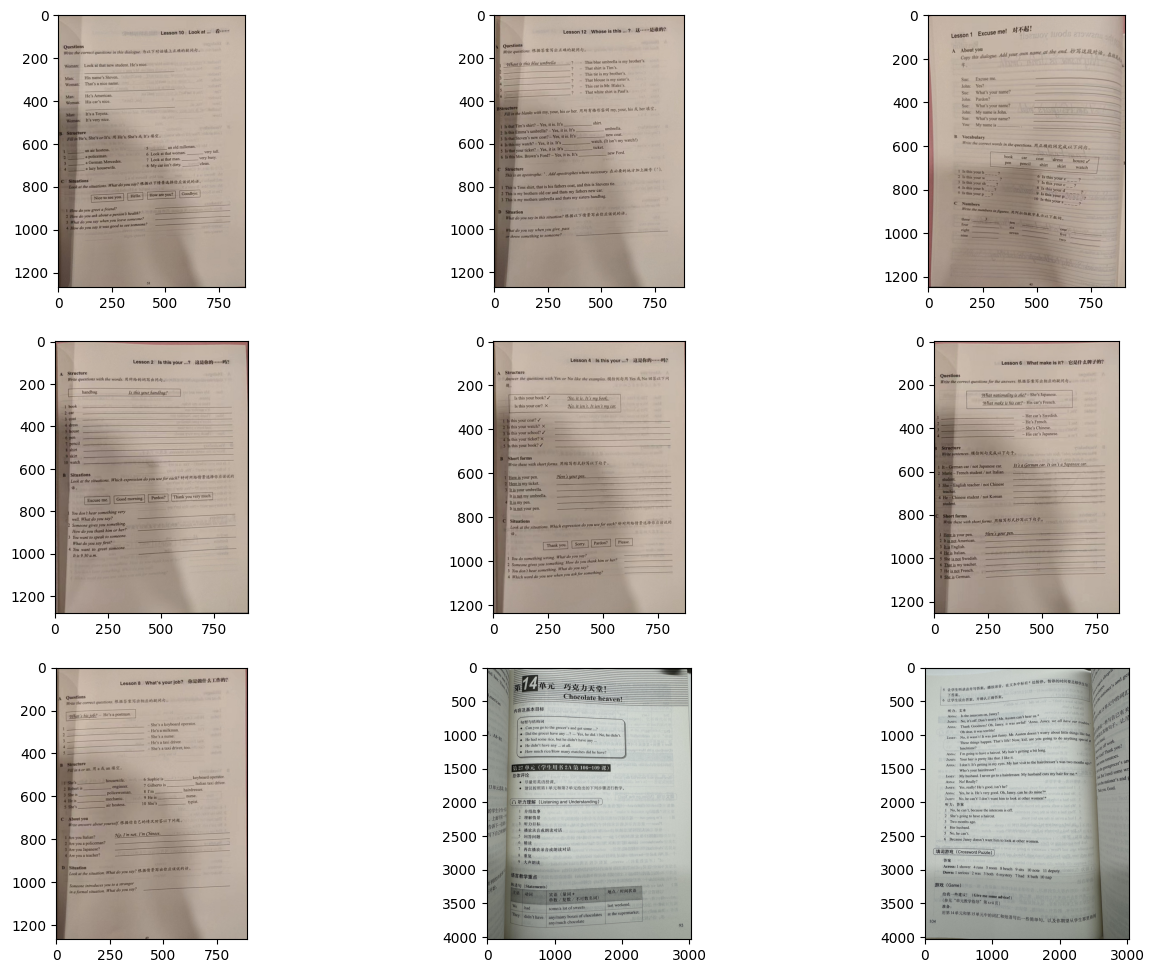

In [15]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    # ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [16]:
# train_list, valid_list = train_test_split(train_list, 
#                                           test_size=0.2,
#                                           stratify=labels,
#                                           random_state=seed)

In [17]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
# print(f"Test Data: {len(test_list)}")

Train Data: 1730
Validation Data: 742


## Image Augmentation

In [18]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [19]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        folder =img_path.parent
        base_name =img_path.stem
        pair_base_name = base_name+'_pdf'+'.jpg'
        img_pair_path = os.path.join(folder, pair_base_name)
        img = Image.open(img_path)
        img_pair = Image.open(img_pair_path)
        
        img_transformed = self.transform(img)
        img_pair_transformed = self.transform(img_pair)
        if img_transformed.shape[0] == 1:
            img_transformed = img_transformed.expand(3, -1, -1)
        if img_pair_transformed.shape[0] == 1:
            img_pair_transformed = img_pair_transformed.expand(3, -1, -1)
        img_transformed_expand = img_transformed.unsqueeze(0)
        img_pair_transformed_expand = img_pair_transformed.unsqueeze(0)
        img_merge = torch.cat((img_transformed_expand,img_pair_transformed_expand),0)
        label = int(str(folder).split("\\")[-1])
        # label = img_path.split("/")[-1].split(".")[0]
        # label = 1 if label == "dog" else 0

        return img_merge, label


In [20]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
# test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [21]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [22]:
print(len(train_data), len(train_loader))

1730 28


In [23]:
print(len(valid_data), len(valid_loader))

742 12


## Efficient Attention

### Linformer

In [24]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [25]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=128,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [26]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [27]:
from torch.nn import Linear
fc = Linear(256,128,bias=True).to(device)
fc2 = Linear(128,2,bias=True).to(device)
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device) #B 2 3 224 224
        label = label.to(device)

        data_0 =data[:,0]
        data_1 =data[:,1]
        output_0 = model(data_0)
        output_1 = model(data_1)
        output_cat = torch.cat((output_0,output_1),1)
        output_linear = fc(output_cat)
        output = fc2(output_linear)
        # output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            data_0 =data[:,0]
            data_1 =data[:,1]
            output_0 = model(data_0)
            output_1 = model(data_1)
            output_cat = torch.cat((output_0,output_1),1)
            val_output_linear = fc(output_cat)
            val_output = fc2(val_output_linear)

            # val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7021 - acc: 0.4732 - val_loss : 0.6956 - val_acc: 0.4849



  0%|          | 0/28 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'vit_model.pth')